In [1]:
# from google.colab import drive
# drive.mount("/content/drive/", force_remount=True)

In [2]:
# import zipfile

# with zipfile.ZipFile("./drive/MyDrive/cell_images.zip") as f:
#   f.extractall("./data")

In [3]:
import torchvision
import os

os.listdir(".")

data_dir = "./data/cell_images"

dataset = torchvision.datasets.ImageFolder(data_dir, transform = torchvision.transforms.ToTensor())

print(len(dataset))
print(dataset.classes)
print(dataset[0][0].shape, dataset[0][1])

27500
['infected', 'uninfected']
torch.Size([3, 64, 64]) 0


In [4]:
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

train_ds, test_ds = random_split(dataset, [25000, 2500])

train_dl = DataLoader(train_ds,100)
test_dl = DataLoader(test_ds,100)

In [5]:
import torch
import torch.nn as nn

class MaleriaModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.network= nn.Sequential(
        # 3 64 64
        nn.Conv2d(3,32,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        # 32 32 32
        nn.Conv2d(32,64,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        # 64 16 16
        nn.Conv2d(64,128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128,128,kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        # 128 4 4
        nn.Flatten(),
        # 128*4*4
        nn.Linear(128*4*4,128),
        nn.ReLU(),
        # 128
        nn.Linear(128,16),
        nn.ReLU(),

        nn.Linear(16,2),
        # 2
    )

  def forward(self,inputs):

    out = self.network(inputs)
    return torch.softmax(out, dim=-1)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = MaleriaModel().to(device)
loss_fn = torch.nn.BCELoss()
opt = torch.optim.SGD(model.parameters(), lr = 3e-2)

cpu


In [7]:

# Trained in google colab for about 20 epochs, got 95% accuracy

import numpy as np

def fit(epochs):
  for epoch in range(epochs):
    print("Epoch: ",epoch)
    for image_batch, label_batch in train_dl:

      targets = []
      for label in label_batch:
        x = np.zeros(2)
        x[int(label)]=1
        targets.append(x.astype(np.float32))

      targets = torch.tensor(targets)
      preds = model(image_batch.to(device))
      
      loss = loss_fn(preds.to(device), targets.to(device))
      loss.backward()

      opt.step()
      opt.zero_grad()

    print("Loss: ",loss.item())

    with torch.no_grad():
      correct = 0
      for image_batch,label_batch in test_dl:

        preds = model(image_batch.to(device))
        preds_cls = []
        for i in range(len(label_batch)):
          if (round(preds[i][label_batch[i]].item()) == 1):
            correct+=1
      
      acc = correct/len(test_ds)
      print("Accuracy: ",round(acc*100,1))

# fit(20)

In [8]:
# loading 96% auurate model weights 

model_pred = MaleriaModel()
try:
    if torch.cuda.is_available():
        model_pred.load_state_dict(torch.load("./saved_models/MaleriaModel.pth"))
    else:
        model_pred.load_state_dict(torch.load("./saved_models/MaleriaModel.pth",map_location=torch.device("cpu")))
except Exception as e:
    print(e)
    print("Error Occured in loading saved weights, training for new weights")
    fit(20)


In [9]:

import matplotlib.pyplot as plt
from PIL import Image

#Enter image path which you want to predict
def predict(path_to_image):
    img = Image.open(path_to_image)
    
    if img.size != (64,64):
        img.resize((64,64))

    img_arr = np.asarray(img)
    plt.imshow(img_arr)
    
    img_arr = img_arr/255
    
    img_tensor = torch.Tensor([img_arr])
    
    img_tensor = img_tensor.permute(0,3,2,1)
    
    pred = model_pred(img_tensor)

    if pred[0][0].item()>=pred[0][1].item():
        print("Infected")
    else:
        print("Uninfected")


C:\Users\ashua\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[0.0060, 0.9940]], grad_fn=<SoftmaxBackward>)
Uninfected


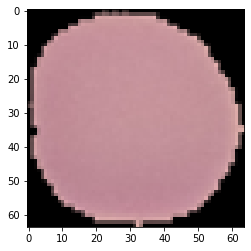

In [10]:
predict("./data/cell_images/uninfected/1000.png")